In [14]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [17]:
feature_columns = [ 'Volume of aeration tanks (m3)', 'Actual Inf rate (m3/d)', '‚ÑÉ Temp.Max.SamplingDate', '‚ÑÉ Temp.Avg.SamplingDate', '‚ÑÉ Temp.Min.SamplingDate', '‚ÑÉ Dew.Max.SamplingDate',
 '‚ÑÉ Dew.Avg.SamplingDate', '‚ÑÉ Dew.Min.SamplingDate', '‚ÑÉ Humidity.Max.SamplingDate', '‚ÑÉ Humidity.Min.SamplingDate', '‚ÑÉ Wind.Max.SamplingDate', '‚ÑÉ Wind.Min.SamplingDate',
 '‚ÑÉ Pressure.Max.SamplingDate', '‚ÑÉ Pressure.Min.SamplingDate', '‚ÑÉ Precipitation.SamplingDate', '‚ÑÉ Temp.Max.WeekMean', '‚ÑÉ Temp.Avg.WeekMean', '‚ÑÉ Temp.Min.WeekMean',
 '‚ÑÉ Dew.Max.WeekMean', '‚ÑÉ Dew.Avg.WeekMean', '‚ÑÉ Dew.Min.WeekMean', '‚ÑÉ Humidity.Max.WeekMean', '‚ÑÉ Humidity.Min.WeekMean', '‚ÑÉ Wind.Max.WeekMean', '‚ÑÉ Wind.Min.WeekMean',
 '‚ÑÉ Pressure.Max.WeekMean', '‚ÑÉ Pressure.Min.WeekMean', '‚ÑÉ Precipitation.WeekMean', '‚ÑÉ Temp.Max.WeekMax', '‚ÑÉ Temp.Avg.WeekMax', '‚ÑÉ Temp.Min.WeekMax', '‚ÑÉ Dew.Max.WeekMax',
 '‚ÑÉ Dew.Avg.WeekMax', '‚ÑÉ Dew.Min.WeekMax', '‚ÑÉ Humidity.Max.WeekMax', '‚ÑÉ Humidity.Min.WeekMax', '‚ÑÉ Wind.Max.WeekMax', '‚ÑÉ Wind.Min.WeekMax', '‚ÑÉ Pressure.Max.WeekMax',
 '‚ÑÉ Pressure.Min.WeekMax', '‚ÑÉ Precipitation.WeekMax', '‚ÑÉ Precipitation.WeekAccum', '‚ÑÉ Precipitation.MonthAccum', '‚ÑÉ Ambient temperature (‚ÑÉ)', 
 'COD (mg/l) In', 'BOD7 (mg/l) In', 'NH3 (mg/L) In', 'Total Nitrogen (mg/L) In', 
 'Total Phosphorus (mg/L) In', 'pH AS', 'DO (mg/L) AS', 'Temp (oC) AS', 'MLSS (mg/l) AS', 'MLVSS (mg/l) AS', 'SVI (ml/g) AS',
 'SRT (days)', 'Precip (inch)', 'Position_enc', 'Country_enc', 'City_enc', 'Plant_enc', 'Year', 'Month', 'Day', 'Weekday', ]

target_column = [ 'performance_class']

In [18]:
original_df = pd.read_csv("../0. Data/modelling_data_250326.csv")
original_df = original_df.fillna(original_df.mean())
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])

original_df['performance_class'] = original_df['COD Removal Rate (mg/L/h)'].apply(lambda x: 1 if x > 400 else  0)
# (lambda x: 2 if x > 0.9 else 1 if x > 0.8 else 0)
original_df['performance_class'].value_counts()

performance_class
0    1165
1      86
Name: count, dtype: int64

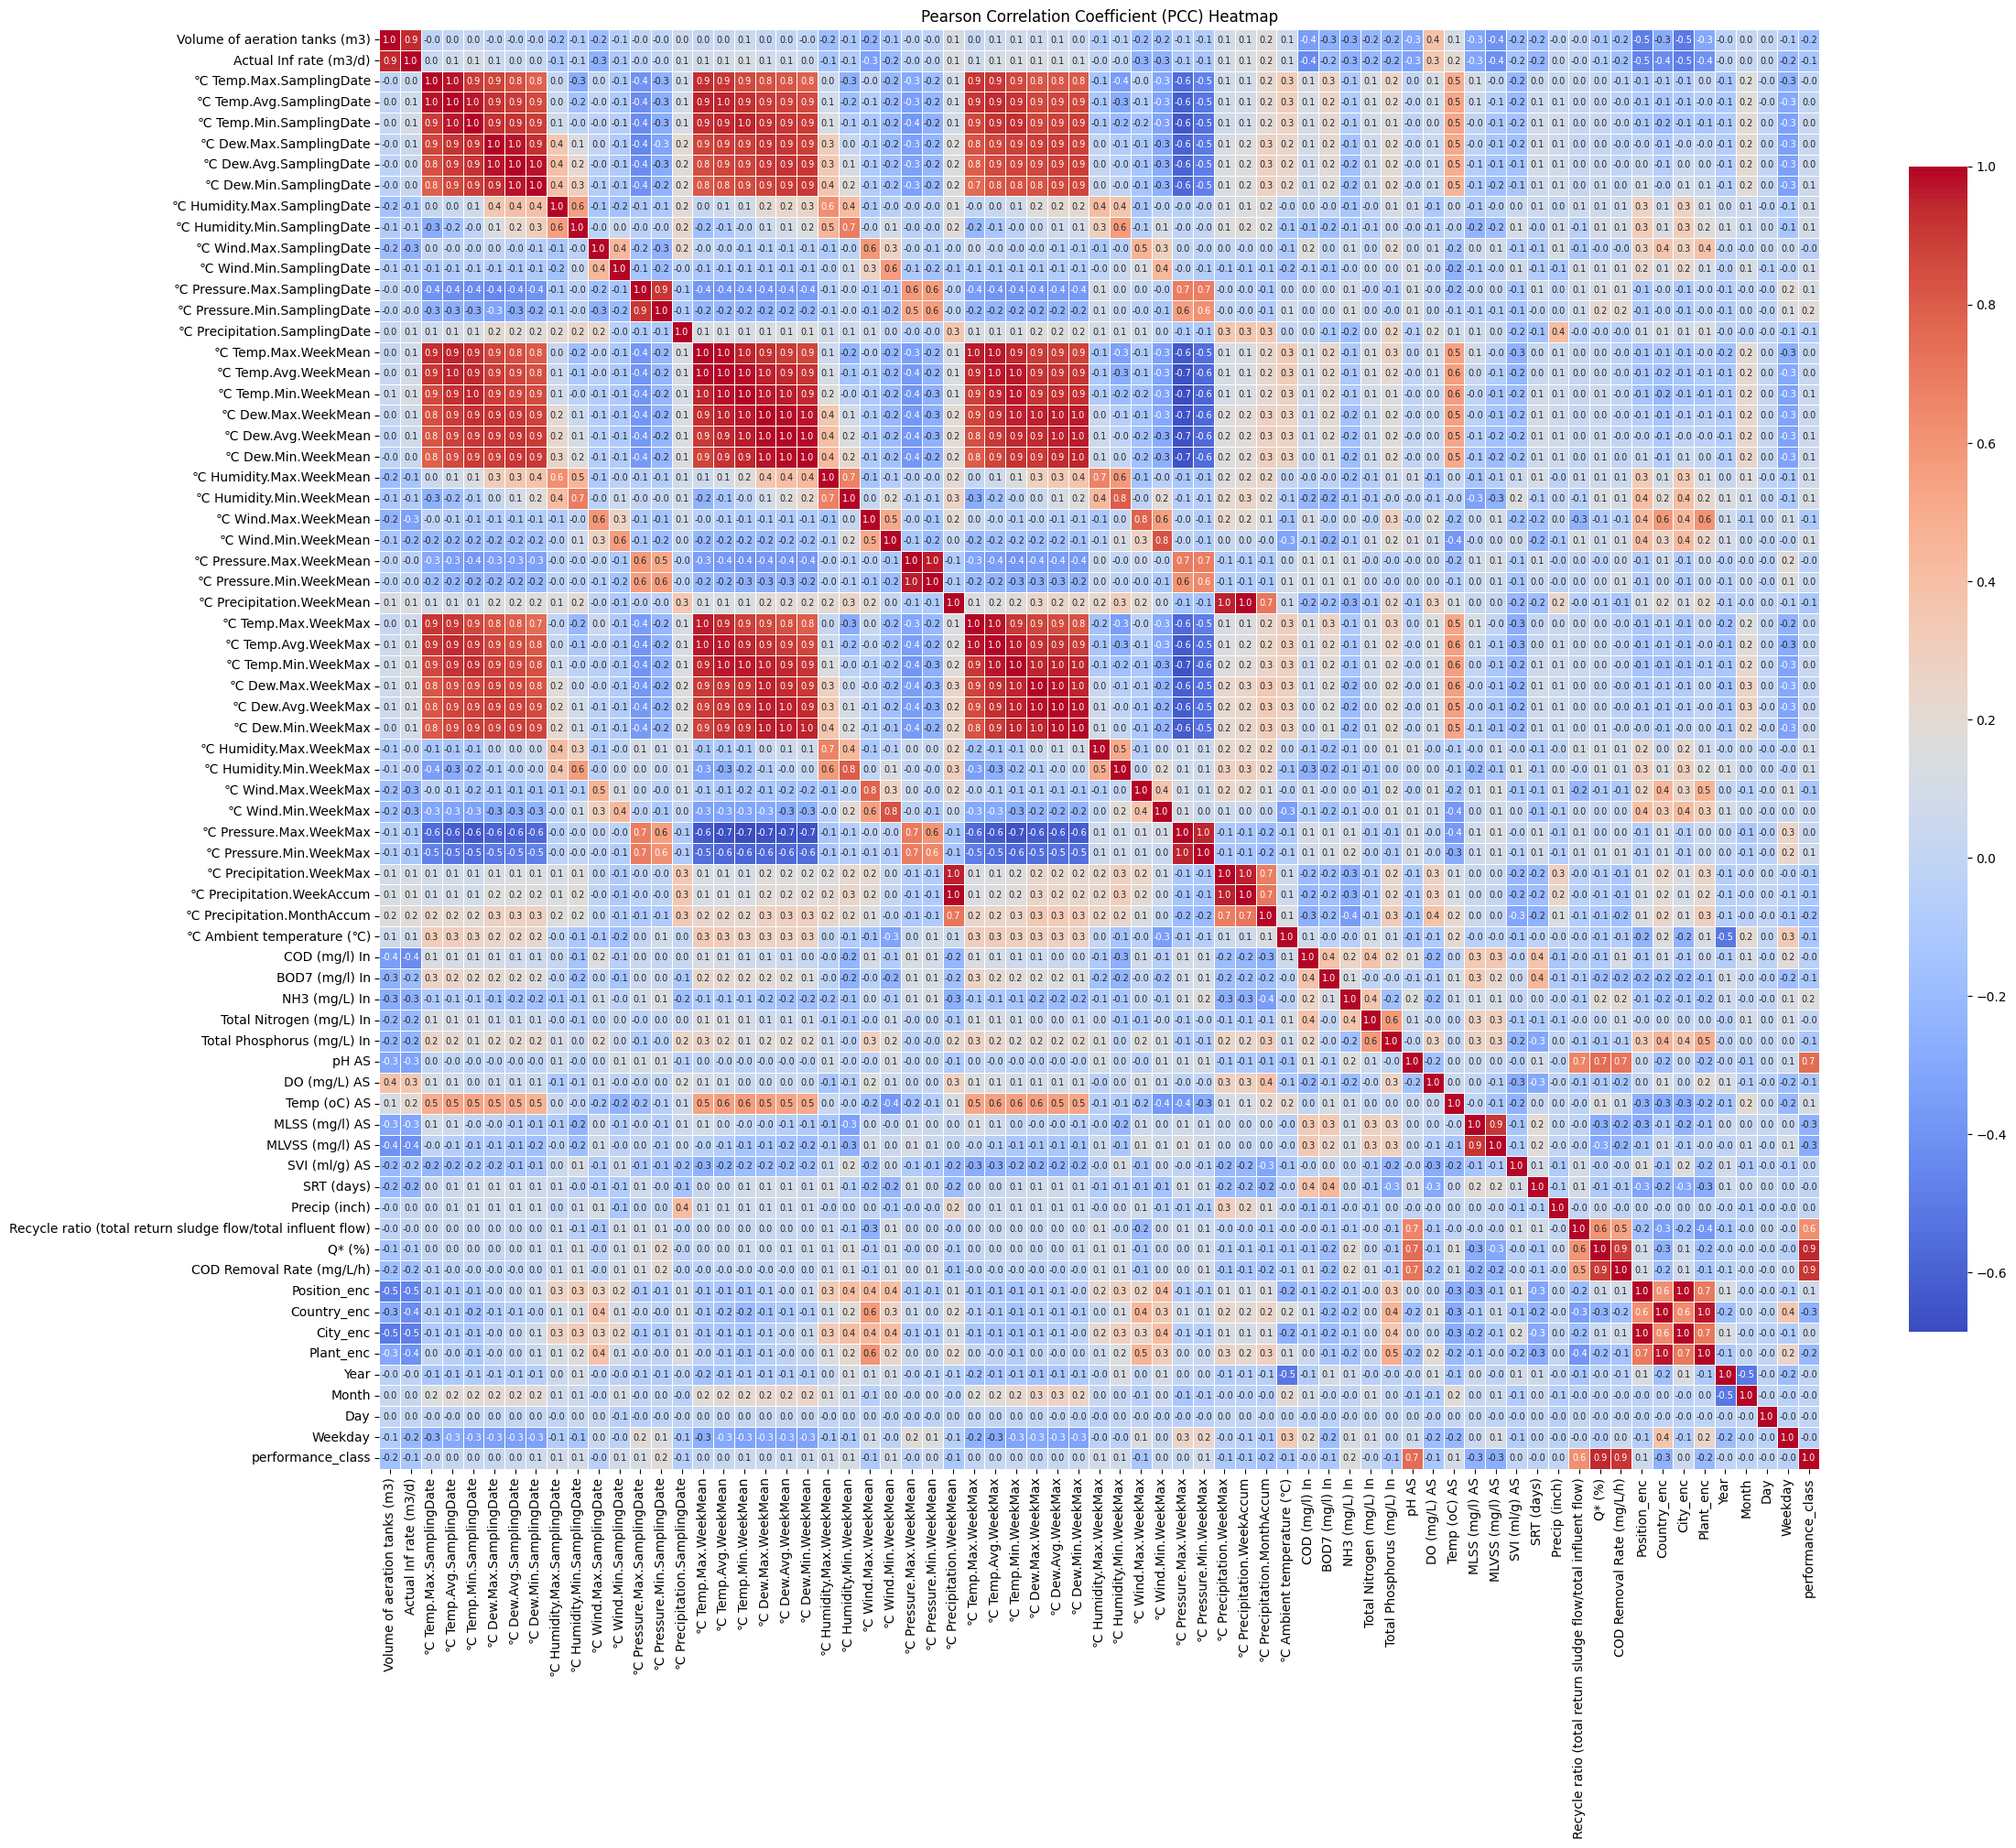

In [19]:
# üîπ ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌñâÎ†¨ Í≥ÑÏÇ∞ (PCC)
corr_matrix = original_df.corr(method='pearson')

# üîπ ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5, annot_kws={"size": 7})
plt.title("Pearson Correlation Coefficient (PCC) Heatmap")
plt.tight_layout()
plt.show()

In [23]:
X = original_df[feature_columns]
y = original_df[target_column].squeeze() 

In [24]:
# üîπ 2. Extract feature and target columns
# Make sure 'feature_columns' and 'target_column' are predefined


# üîπ 3. Split the data into training and test sets (70:30 split with random seed 1004)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1004)

# üîπ 4. Normalize feature values using standard scaling (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("NaNs in X_train:", np.isnan(X_train_scaled).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in X_train:", np.isinf(X_train_scaled).sum())
print("Infs in y_train:", np.isinf(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0
Infs in X_train: 0
Infs in y_train: 0


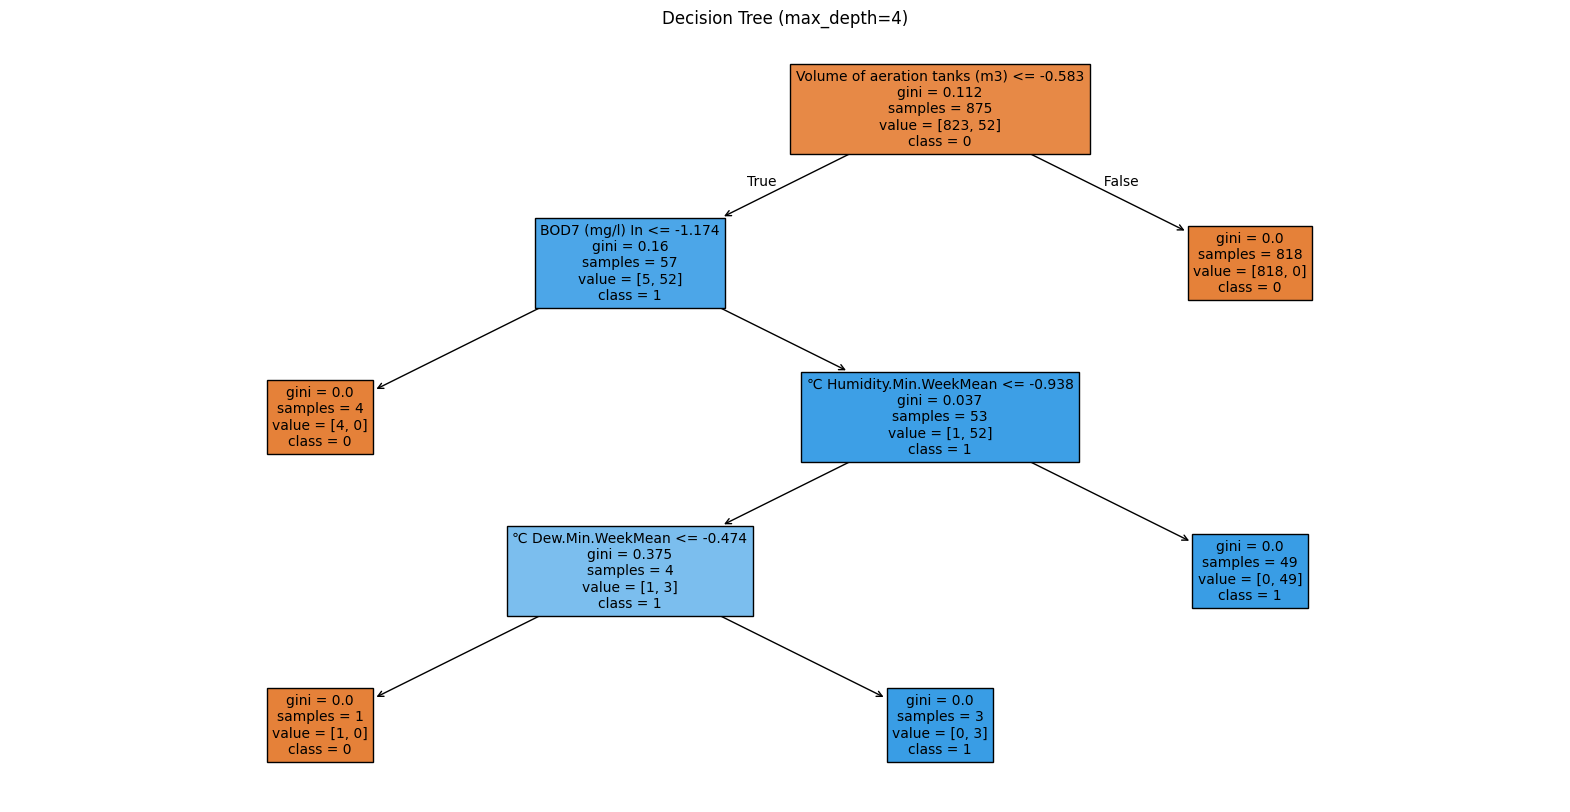

In [25]:
# üîπ 1. Î™®Îç∏ ÌïôÏäµ
clf = DecisionTreeClassifier(max_depth=4, random_state=1004)
clf.fit(X_train_scaled, y_train)

# üîπ 2. Ìä∏Î¶¨ Íµ¨Ï°∞ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=[str(c) for c in sorted(y.unique())],
          filled=True,
          fontsize=10)
plt.title("Decision Tree (max_depth=4)")
plt.show()


In [26]:
# üîπ 8. Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


28/28 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 828us/step
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 360us/step


In [28]:
# üîπ 3. ÏÑ±Îä• ÌèâÍ∞Ä
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      1.00      1.00       342
           1       1.00      0.94      0.97        34

    accuracy                           0.99       376
   macro avg       1.00      0.97      0.98       376
weighted avg       0.99      0.99      0.99       376



In [29]:
# üîπ 4. SHAP ÏÑ§Î™Ö Ï§ÄÎπÑ (ÏûÖÎ†•ÏùÑ DataFrameÏúºÎ°ú Î≥ÄÌôò)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

explainer = shap.Explainer(clf, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df)  # shap_valuesÎäî Explanation Í∞ùÏ≤¥



## SHAP analysis

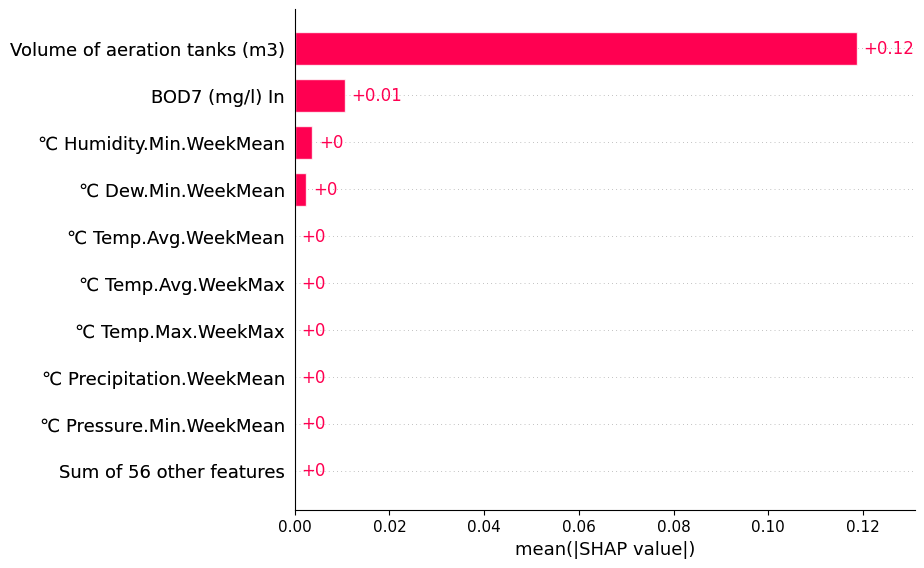

In [30]:
# Ïòà: ÌÅ¥ÎûòÏä§ 0Ïóê ÎåÄÌïú Ï†ÑÏó≠ feature importance ÏãúÍ∞ÅÌôî
shap.plots.bar(shap_values[:, :, 0])  # Ï§ëÏöî! Îã§Ï§ë ÌÅ¥ÎûòÏä§Îäî Ïù¥Î†áÍ≤å slicingÌï¥Ïïº Ìï®


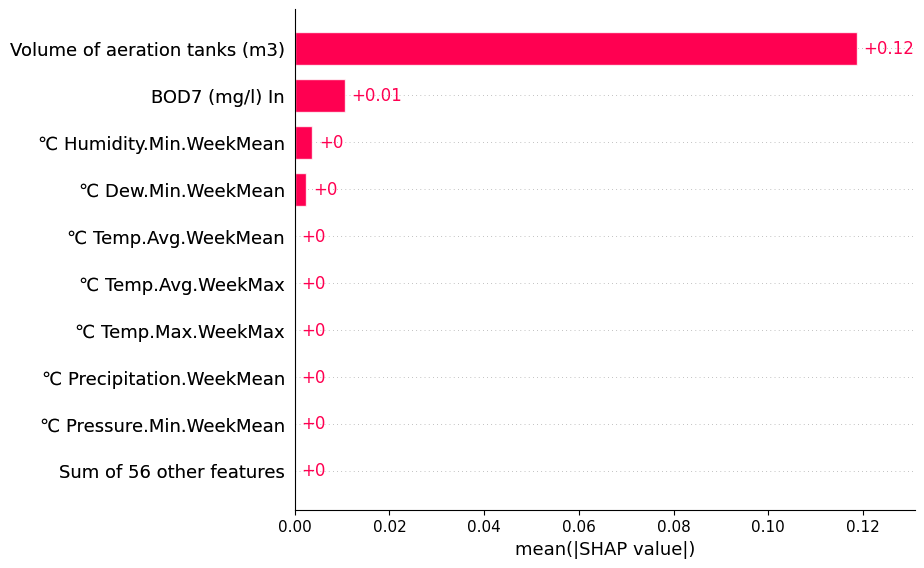

In [31]:
shap.plots.bar(shap_values[:, :, 1]) 

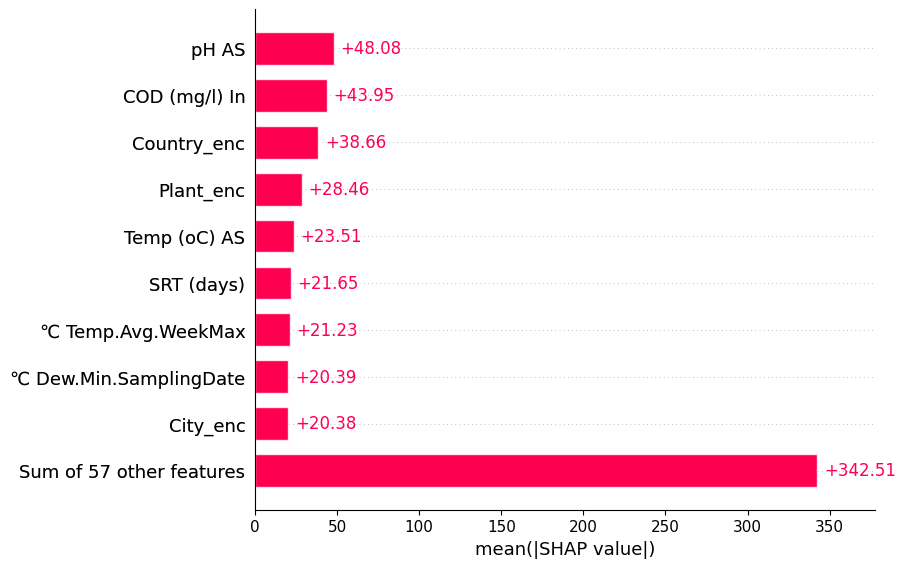

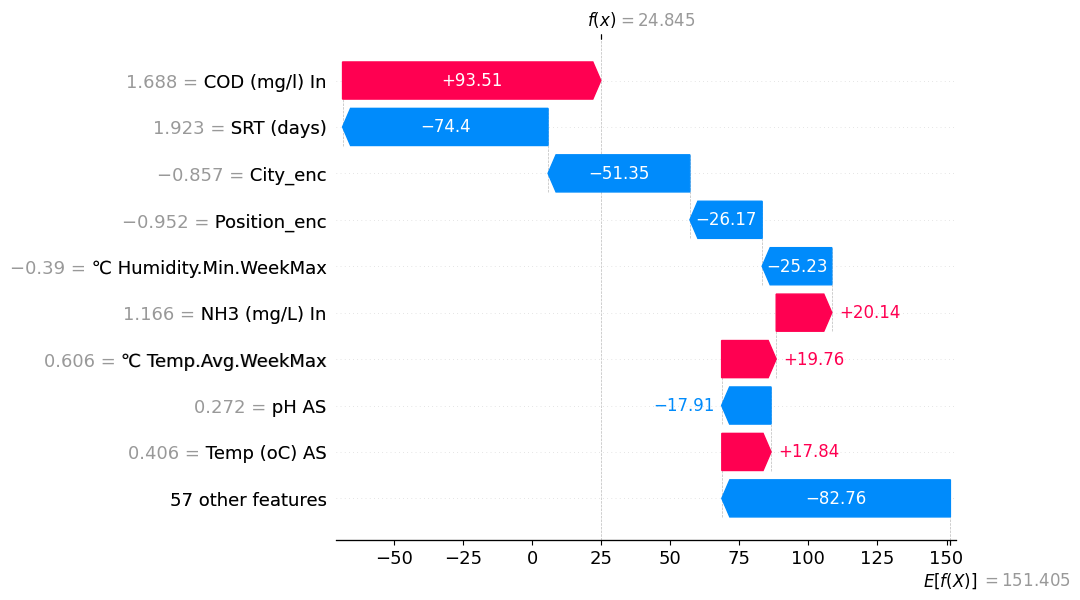

In [14]:
# Ï†ÑÏó≠ feature importance ÏãúÍ∞ÅÌôî
shap.plots.bar(shap_values)

# ÌäπÏ†ï ÏÉòÌîåÏóê ÎåÄÌïú Ìï¥ÏÑù (Ïòà: Ï≤´ Î≤àÏß∏ ÏÉòÌîå)
shap.plots.waterfall(shap_values[0])